<a href="https://colab.research.google.com/github/Mahdi-Golizadeh/MODEL-COMPRESSION/blob/main/linear_quantization/CompleteQuantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import necessary libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch

utility functions

In [2]:
def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=None):
    """
    Plot a heatmap of tensors using seaborn
    """
    sns.heatmap(tensor.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


def plot_quantization_errors(original_tensor, quantized_tensor, dequantized_tensor, dtype = torch.int8, n_bits = 8):
    """
    A method that plots 4 matrices, the original tensor, the quantized tensor
    the de-quantized tensor and the error tensor.
    """
    # Get a figure of 4 plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the first matrix
    plot_matrix(original_tensor, axes[0], 'Original Tensor', cmap=ListedColormap(['white']))

    # Get the quantization range and plot the quantized tensor
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    plot_matrix(quantized_tensor, axes[1], f'{n_bits}-bit Linear Quantized Tensor', vmin=q_min, vmax=q_max, cmap='coolwarm')

    # Plot the de-quantized tensors
    plot_matrix(dequantized_tensor, axes[2], 'Dequantized Tensor', cmap='coolwarm')

    # Get the quantization errors
    q_error_tensor = abs(original_tensor - dequantized_tensor)
    plot_matrix(q_error_tensor, axes[3], 'Quantization Error Tensor', cmap=ListedColormap(['white']))

    fig.tight_layout()
    plt.show()

linear quantization and dequantization functions

In [3]:
def linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype = torch.int8):
    scaled_and_shifted_tensor = tensor / scale + zero_point
    rounded_tensor = torch.round(scaled_and_shifted_tensor)
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max
    q_tensor = rounded_tensor.clamp(q_min,q_max).to(dtype)

    return q_tensor


def linear_dequantization(quantized_tensor, scale, zero_point):
    return scale * (quantized_tensor.float() - zero_point)

function to get scale and zero

In [4]:
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):

    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()

    scale = (r_max - r_min) / (q_max - q_min)

    zero_point = q_min - (r_min / scale)

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        # round and cast to int
        zero_point = int(round(zero_point))

    return scale, zero_point

put everything together

In [5]:
def linear_quantization(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor,
                                                   dtype=dtype)

    quantized_tensor = linear_q_with_scale_and_zero_point(tensor,
                                                          scale,
                                                          zero_point,
                                                          dtype=dtype)

    return quantized_tensor, scale , zero_point

now to test the function

In [6]:
r_tensor = torch.randn((4, 4))

In [7]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)

In [8]:
dequantized_tensor = linear_dequantization(quantized_tensor,
                                           scale, zero_point)

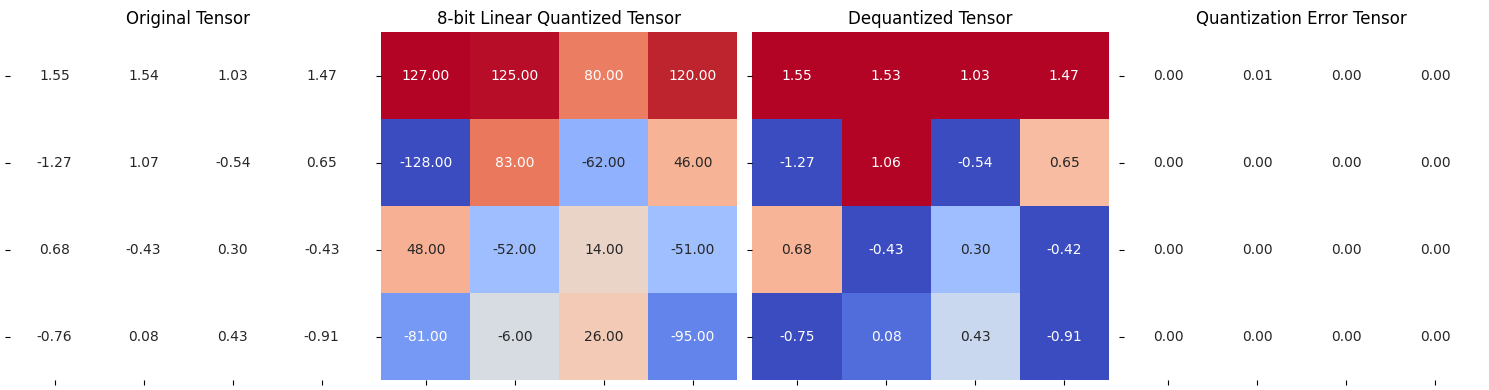

In [9]:
plot_quantization_errors(r_tensor, quantized_tensor,
                         dequantized_tensor)

getting mean squared error

In [10]:
(dequantized_tensor-r_tensor).square().mean()

tensor(1.0646e-05)